In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
#from gensim.models import KeyedVectors


In [3]:
train = "C:\\Users\\SONY\\Desktop\\WORK\\PROJECT\\train.xlsx"
test = "C:\\Users\\SONY\\Desktop\\WORK\\PROJECT\\Test.xlsx"

In [4]:

df = pd.read_excel(train)
df.Text = df.Text.str.replace('[^\w\s]','')
df.Text = df.Text.str.lower()
#df.Text = df.Text.str.split()

df1 = pd.read_excel(test)
df1.Text = df1.Text.str.replace('[^\w\s]','')
df1.Text = df1.Text.str.lower()
#df1.Text = df1.Text.str.split()

## TACKLING WITH UNBALANCED DATASET

In [5]:
len(df1[df1['Labels']==1])

41

In [6]:
len(df[df['Labels']==1]),len(df[df['Labels']==0])

(20, 132)

In [7]:
A= df[df['Labels']==1]
B= df[df['Labels']==0]

In [8]:
A_repeated = pd.concat([A]*7, ignore_index=True)
df = pd.concat([A_repeated,B])
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)

## FURTHER PRE-PROCESSING

In [117]:
#from nltk.corpus import stopwords 
#from nltk.tokenize import word_tokenize 

In [118]:
#stop = stopwords.words('english')
#df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [10]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [11]:
df['Text'] = df.Text.apply(lemmatize_text)

In [12]:
#df1['Text'] = df1['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df1['Text'] = df1.Text.apply(lemmatize_text)

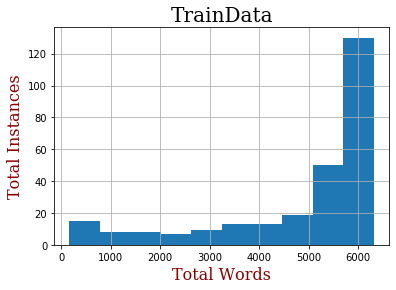

count     272.000000
mean     4828.805147
std      1677.848533
min       163.000000
25%      4240.750000
50%      5692.000000
75%      5915.000000
max      6320.000000
dtype: float64

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
Text_len = [len(x) for x in df.Text]
pd.Series(Text_len).hist()
plt.xlabel('Total Words', fontdict= {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,})
plt.ylabel('Total Instances',fontdict= {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,})
plt.title('TrainData', fontdict ={'family': 'serif','color':  'black','weight': 'normal','size': 20,})
plt.show()
pd.Series(Text_len).describe()

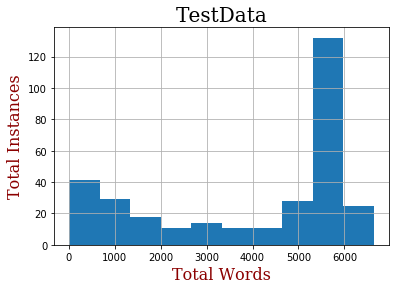

count     320.000000
mean     3987.731250
std      2156.238002
min        10.000000
25%      1627.500000
50%      5290.500000
75%      5719.500000
max      6642.000000
dtype: float64

In [14]:
Text_len1 = [len(x) for x in df1.Text]
pd.Series(Text_len1).hist()
plt.xlabel('Total Words', fontdict= {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,})
plt.ylabel('Total Instances',fontdict= {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,})
plt.title('TestData', fontdict ={'family': 'serif','color':  'black','weight': 'normal','size': 20,})
plt.show()
pd.Series(Text_len1).describe()

## LOADING GLOVE VECTORS

In [122]:
class GloveVectorizer:
    def __init__(self):
        # load in pre-trained word vectors
        print('Loading word vectors...')
        word2vec = {}
        embedding = []
        idx2word = []
        with open('C:\\Users\\SONY\\Desktop\\WORK\\New\\glove\\glove.6B.100d.txt',encoding='utf') as f:
            # is just a space-separated text file in the format:
            # word vec[0] vec[1] vec[2] ...
            for line in f:
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
                embedding.append(vec)
                idx2word.append(word)
        print('Found %s word vectors.' % len(word2vec))

        # save for later
        self.word2vec = word2vec
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape

    def fit(self, data):
        pass

    def transform(self, data):
        X = np.zeros((len(data), self.D))
        Y = np.zeros((len(data), self.D))
        Z = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            #tokens = sentence.lower().split()
            vecs = []
            for word in sentence:
                if word in self.word2vec:
                    vec = self.word2vec[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
                Y[n] = vecs.min(axis=0)
                Z[n] = vecs.max(axis=0)
                
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X,Y,Z

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [123]:
vectorizer = GloveVectorizer()
# vectorizer = Word2VecVectorizer()
Xavg,Xmin,Xmax = vectorizer.fit_transform(df.Text)
Ytrain = df.Labels
Test_avg,Test_min,Test_max = vectorizer.transform(df1.Text)
Ytest = df1.Labels

Loading word vectors...
Found 400000 word vectors.
Number of samples with no words found: 0 / 272
Number of samples with no words found: 0 / 320


In [124]:
Xavg.shape, Xavg

((272, 100), array([[-0.08210665,  0.24296233,  0.32847109, ..., -0.27452844,
          0.43058041,  0.23358656],
        [-0.10068361,  0.22685106,  0.30363446, ..., -0.25213444,
          0.47252768,  0.14023894],
        [-0.09521415,  0.19471765,  0.34869123, ..., -0.28735396,
          0.4396182 ,  0.1954027 ],
        ...,
        [-0.10615186,  0.22632921,  0.39993405, ..., -0.30264559,
          0.35592282,  0.24975191],
        [-0.08805366,  0.24106307,  0.3561067 , ..., -0.27348304,
          0.39895487,  0.24565068],
        [-0.04922622,  0.29443663,  0.38274023, ..., -0.3154425 ,
          0.36513478,  0.2611053 ]]))

## TRYING SIMPLER ML MODELS

In [125]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear',class_weight='balanced',random_state=5,tol=0.001,max_iter=1000000)

In [126]:
#model = RandomForestClassifier(n_estimators=200)
model.fit(Xavg, Ytrain)
print("train score:", model.score(Xavg, Ytrain))
print("test score:", model.score(Test_avg, Ytest))


train score: 0.8676470588235294
test score: 0.88125


In [127]:
predictions = model.predict(Test_avg)

In [128]:
from sklearn.metrics import precision_score, recall_score,accuracy_score, classification_report, f1_score ,confusion_matrix


In [151]:
cm = confusion_matrix(Ytest,predictions)
print(cm)
print('\n',classification_report(Ytest,predictions))


[[250  29]
 [  9  32]]

               precision    recall  f1-score   support

           0       0.97      0.90      0.93       279
           1       0.52      0.78      0.63        41

    accuracy                           0.88       320
   macro avg       0.74      0.84      0.78       320
weighted avg       0.91      0.88      0.89       320



In [152]:
model.fit(Xmax, Ytrain)
predictions2 = model.predict(Test_max)
cm2 = confusion_matrix(Ytest,predictions2)
print(cm2)
print('\n',classification_report(Ytest,predictions2))

[[260  19]
 [ 17  24]]

               precision    recall  f1-score   support

           0       0.94      0.93      0.94       279
           1       0.56      0.59      0.57        41

    accuracy                           0.89       320
   macro avg       0.75      0.76      0.75       320
weighted avg       0.89      0.89      0.89       320



In [153]:
model.fit(Xmin, Ytrain)
predictions3 = model.predict(Test_min)
cm3 = confusion_matrix(Ytest,predictions3)
print(cm3)
print('\n',classification_report(Ytest,predictions3))

[[252  27]
 [ 16  25]]

               precision    recall  f1-score   support

           0       0.94      0.90      0.92       279
           1       0.48      0.61      0.54        41

    accuracy                           0.87       320
   macro avg       0.71      0.76      0.73       320
weighted avg       0.88      0.87      0.87       320



In [164]:
from sklearn import svm
SVMM = svm.LinearSVC(class_weight='balanced',verbose=0, random_state=None,max_iter=1000)  

In [165]:
SVMM.fit(Xavg, Ytrain)
predictions4 = SVMM.predict(Test_avg)
cm4 = confusion_matrix(Ytest,predictions4)
print("train score:", SVMM.score(Xavg, Ytrain))
print("test score:", SVMM.score(Test_avg, Ytest))
print('\n',cm4)
print('\n',classification_report(Ytest,predictions4))

train score: 0.9191176470588235
test score: 0.9

 [[255  24]
 [  8  33]]

               precision    recall  f1-score   support

           0       0.97      0.91      0.94       279
           1       0.58      0.80      0.67        41

    accuracy                           0.90       320
   macro avg       0.77      0.86      0.81       320
weighted avg       0.92      0.90      0.91       320



# FINAL MODEL FOR CLASSIFICATION

In [167]:
import pickle
#import sklearn
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [138]:
train_x = np.dstack([Xavg,Xmin,Xmax])

In [139]:
train_x.shape

(272, 100, 3)

In [140]:
train_x = train_x.reshape(272, 1,100, 3)

In [141]:
test_x = np.dstack([Test_avg,Test_min,Test_max])

In [142]:
test_x.shape

(320, 100, 3)

In [143]:
test_x = test_x.reshape(320, 1,100, 3)

In [149]:
train_y = np.asarray(pd.get_dummies(Ytrain), dtype = np.int8)
test_y = np.asarray(pd.get_dummies(Ytest), dtype = np.int8)

In [150]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((272, 1, 100, 3), (272, 2), (320, 1, 100, 3), (320, 2))

## DEFINING HELPER FUNCTIONS

In [296]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))
    
def apply_pooling(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')


## MODEL PARAMETERS

In [472]:
input_height = 1
input_width = 100
num_labels = 2
num_channels = 3

batch_size = 8
kernel_size = 10
nbr_kernels = 30
num_hidden = 128

learning_rate = 0.001
momentum=0.9
decay_rate = 0.0005
epsilon = 0.01
training_epochs = 30

total_batches = train_x.shape[0] // batch_size


## BUILDING THE LAYERS

In [473]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_conv(X,kernel_size,num_channels,nbr_kernels)        #FILTER LAYER 1
p = apply_pooling(c,8,2)                                     #POOLING LAYER 1

shape = p.get_shape().as_list()
p_flat = tf.reshape(p, [-1, shape[1] * shape[2] * shape[3]])

W = weight_variable([shape[1] * shape[2] * nbr_kernels * num_channels, num_hidden])
b = bias_variable([num_hidden])
f = tf.nn.relu(tf.add(tf.matmul(p_flat, W),b))

W2 = weight_variable([num_hidden, num_hidden])
b2 = bias_variable([num_hidden])
f2 = tf.nn.relu(tf.add(tf.matmul(f, W2),b2))


out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
softmax_out = tf.nn.softmax(tf.matmul(f2, out_weights) + out_biases)



In [474]:
loss = -tf.reduce_sum(Y * tf.log(softmax_out))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay= decay_rate , momentum= momentum,epsilon= epsilon, use_locking=False, centered=False, name='RMSProp').minimize(loss)
correct_prediction = tf.equal(tf.argmax(softmax_out,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TRAINING

In [475]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    #summary_writer = tf.summary.FileWriter('./tensor/logs', graph=tf.get_default_graph())
    saver = tf.train.Saver()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            #_, c,summary = session.run([optimizer, loss,merged],feed_dict={X: batch_x, Y : batch_y})
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
            #summary_writer.add_summary(summary, epoch)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))
    preds = session.run(softmax_out, feed_dict={X: test_x, Y: test_y})
    #save_path = saver.save(session, "/tmp/model.ckpt")
    #print("Model saved in path: %s" % save_path)

Epoch:  0  Training Loss:  8.127902  Training Accuracy:  0.5147059
Epoch:  1  Training Loss:  7.176163  Training Accuracy:  0.5147059
Epoch:  2  Training Loss:  11.648097  Training Accuracy:  0.5147059
Epoch:  3  Training Loss:  5.6405516  Training Accuracy:  0.5808824
Epoch:  4  Training Loss:  5.721657  Training Accuracy:  0.8308824
Epoch:  5  Training Loss:  6.4016666  Training Accuracy:  0.7647059
Epoch:  6  Training Loss:  5.326806  Training Accuracy:  0.8492647
Epoch:  7  Training Loss:  6.002383  Training Accuracy:  0.5514706
Epoch:  8  Training Loss:  13.762344  Training Accuracy:  0.54044116
Epoch:  9  Training Loss:  6.557444  Training Accuracy:  0.8602941
Epoch:  10  Training Loss:  8.6622505  Training Accuracy:  0.5625
Epoch:  11  Training Loss:  6.3283815  Training Accuracy:  0.8602941
Epoch:  12  Training Loss:  7.836132  Training Accuracy:  0.5330882
Epoch:  13  Training Loss:  5.872313  Training Accuracy:  0.64705884
Epoch:  14  Training Loss:  4.973226  Training Accura

In [479]:
preds.shape

(320, 2)

In [482]:
preds

array([[8.15956155e-05, 9.99918342e-01],
       [6.82287675e-04, 9.99317765e-01],
       [2.77755465e-02, 9.72224414e-01],
       [3.29843780e-04, 9.99670148e-01],
       [8.53915651e-07, 9.99999166e-01],
       [4.00717705e-01, 5.99282324e-01],
       [2.35620129e-04, 9.99764383e-01],
       [6.18038292e-04, 9.99381900e-01],
       [2.55319919e-03, 9.97446775e-01],
       [1.22752752e-07, 9.99999881e-01],
       [1.43172201e-02, 9.85682786e-01],
       [9.40419555e-01, 5.95804490e-02],
       [2.04806542e-03, 9.97951925e-01],
       [1.76792742e-06, 9.99998212e-01],
       [9.97408569e-01, 2.59148609e-03],
       [1.66896876e-04, 9.99833107e-01],
       [2.04239171e-02, 9.79576111e-01],
       [4.86929379e-02, 9.51307118e-01],
       [9.99995470e-01, 4.48731726e-06],
       [5.89533627e-01, 4.10466462e-01],
       [9.76662397e-01, 2.33376063e-02],
       [9.98351336e-01, 1.64869963e-03],
       [7.93320715e-01, 2.06679285e-01],
       [8.19925308e-01, 1.80074707e-01],
       [9.998734

In [480]:
final_pred=[]
for i in preds:
    final_pred.append(np.argmax(i))

In [481]:
cm5 = confusion_matrix(Ytest,final_pred)
print('\n',cm5)
print('\n',classification_report(Ytest,final_pred))


 [[249  30]
 [  6  35]]

               precision    recall  f1-score   support

           0       0.98      0.89      0.93       279
           1       0.54      0.85      0.66        41

    accuracy                           0.89       320
   macro avg       0.76      0.87      0.80       320
weighted avg       0.92      0.89      0.90       320

